In [ ]:

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


In [2]:
import matplotlib.pyplot as plt
import scipy as sp
import numpy as np
import pandas as pd

In [3]:
!pip install gdown

In [4]:
# Downloading the data from the gdrive folder
import gdown

file_id = "1KKPx9hp9wBTpjal0Ejg0s0L3Ysslym6Q"
output_file = "clean_data_file.zip"

gdown.download(f"https://drive.google.com/uc?id={file_id}", output_file)

# unzip the data file
!unzip clean_data_file.zip

Downloading...
From (original): https://drive.google.com/uc?id=1KKPx9hp9wBTpjal0Ejg0s0L3Ysslym6Q
From (redirected): https://drive.google.com/uc?id=1KKPx9hp9wBTpjal0Ejg0s0L3Ysslym6Q&confirm=t&uuid=67de701c-fe14-4ca9-bb77-b278b4e3e9f4
To: /kaggle/working/clean_data_file.zip
100%|██████████| 236M/236M [00:05<00:00, 43.9MB/s]


Archive:  clean_data_file.zip
  inflating: 100k_pos_tr_spec_R100.csv  


In [5]:
# Reading the Data from the csv file containing the spectra and the parameters
file_path = '100k_pos_tr_spec_R100.csv'
data = np.genfromtxt(file_path, delimiter=',',skip_header=1)

In [6]:
data.shape

(98664, 280)

In [7]:
train_data = data
new_spec = np.zeros_like(train_data[:,:269])
for i in range(len(train_data)):
    mean_sp = np.mean(train_data[i,:269])
    std_sp = np.std(train_data[i,:269])
    new_spec[i,:269] = (train_data[i,:269] - mean_sp) / std_sp

In [8]:
X = new_spec
Y = data[:,274:]
X.shape, Y.shape

((98664, 269), (98664, 6))

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.15, random_state = 42)

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [10]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((83864, 269, 1), (14800, 269, 1), (83864, 6), (14800, 6))

In [11]:
import tensorflow as tf

2024-07-24 22:31:48.251842: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-24 22:31:48.251957: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-24 22:31:48.387538: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [12]:

def create_model(input_shape):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(tf.keras.layers.MaxPooling1D())
    model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(tf.keras.layers.MaxPooling1D())
    model.add(tf.keras.layers.Conv1D(128, 3, activation='relu'))
    model.add(tf.keras.layers.MaxPooling1D())
    model.add(tf.keras.layers.Conv1D(64, 3, activation='relu'))
    model.add(tf.keras.layers.Flatten())
    
    model.add(tf.keras.layers.Dense(256, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.09))
    model.add(tf.keras.layers.Dense(64, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.09))
    model.add(tf.keras.layers.Dense(32, activation='relu'))
    model.add(tf.keras.layers.Dense(y_train.shape[1], activation='linear'))
    return model


input_shape = (X_train.shape[1], X_train.shape[2])
model = create_model(input_shape)
opt =  tf.keras.optimizers.Adam(1e-3)
model.compile(optimizer=opt, loss='mse', metrics=['mae','r2_score'])
model.summary()
exolab=model.fit(X_train, y_train, epochs=50,batch_size=32,
                    validation_split=0.2,shuffle=True)


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 267, 32)        │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 133, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 131, 64)        │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 65, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 63, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 31, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 29, 64)         │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1856)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       475,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 549,798 (2.10 MB)

 Trainable params: 549,798 (2.10 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
  44/2097 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 12.4869 - mae: 2.8309 - r2_score: -2.2496

I0000 00:00:1721860326.967862      76 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2097/2097 ━━━━━━━━━━━━━━━━━━━━ 23s 7ms/step - loss: 2.4927 - mae: 1.1747 - r2_score: 0.3399 - val_loss: 0.8131 - val_mae: 0.6588 - val_r2_score: 0.7867
Epoch 2/50
2097/2097 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.7998 - mae: 0.6749 - r2_score: 0.7876 - val_loss: 0.4965 - val_mae: 0.5084 - val_r2_score: 0.8690
Epoch 3/50
2097/2097 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.5910 - mae: 0.5721 - r2_score: 0.8429 - val_loss: 0.4210 - val_mae: 0.4667 - val_r2_score: 0.8891
Epoch 4/50
2097/2097 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.4709 - mae: 0.5062 - r2_score: 0.8745 - val_loss: 0.3953 - val_mae: 0.4540 - val_r2_score: 0.8955
Epoch 5/50
2097/2097 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.4078 - mae: 0.4688 - r2_score: 0.8909 - val_loss: 0.3562 - val_mae: 0.4408 - val_r2_score: 0.9063
Epoch 6/50
2097/2097 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.3663 - mae: 0.4431 - r2_score: 0.9020 - val_loss: 0.3149 - val_mae: 0.4071 - val_r2_score: 0.9153
Epoch 7/50
2097/2097 ━━━━━━━━━━━━━━━━━

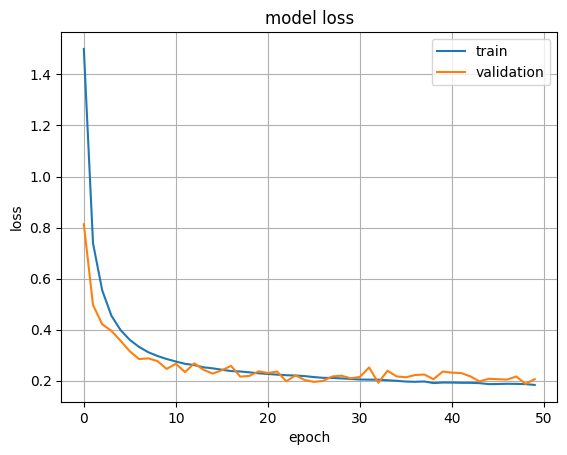

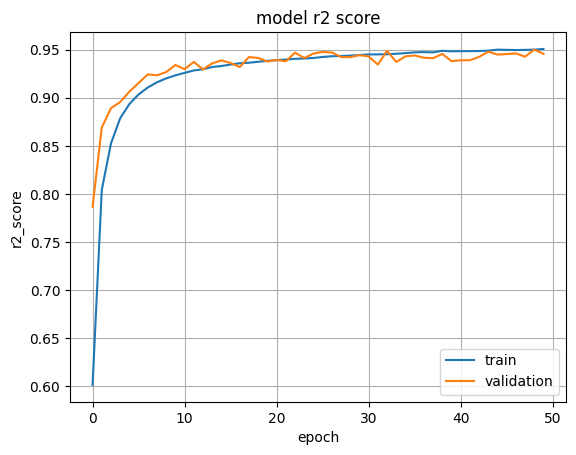

In [13]:
# loss
plt.plot(exolab.history['loss'])
plt.plot(exolab.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.grid(True)
plt.show()

# r2 score
plt.plot(exolab.history['r2_score'])
plt.plot(exolab.history['val_r2_score'])
plt.title('model r2 score')
plt.ylabel('r2_score')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.grid(True)
plt.show()

In [14]:
test_loss,test_mae,test_r2_score = model.evaluate(X_test,y_test)

463/463 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2040 - mae: 0.3124 - r2_score: 0.9459


In [15]:
predictions = model.predict(X_test)
predictions.shape

463/463 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


(14800, 6)

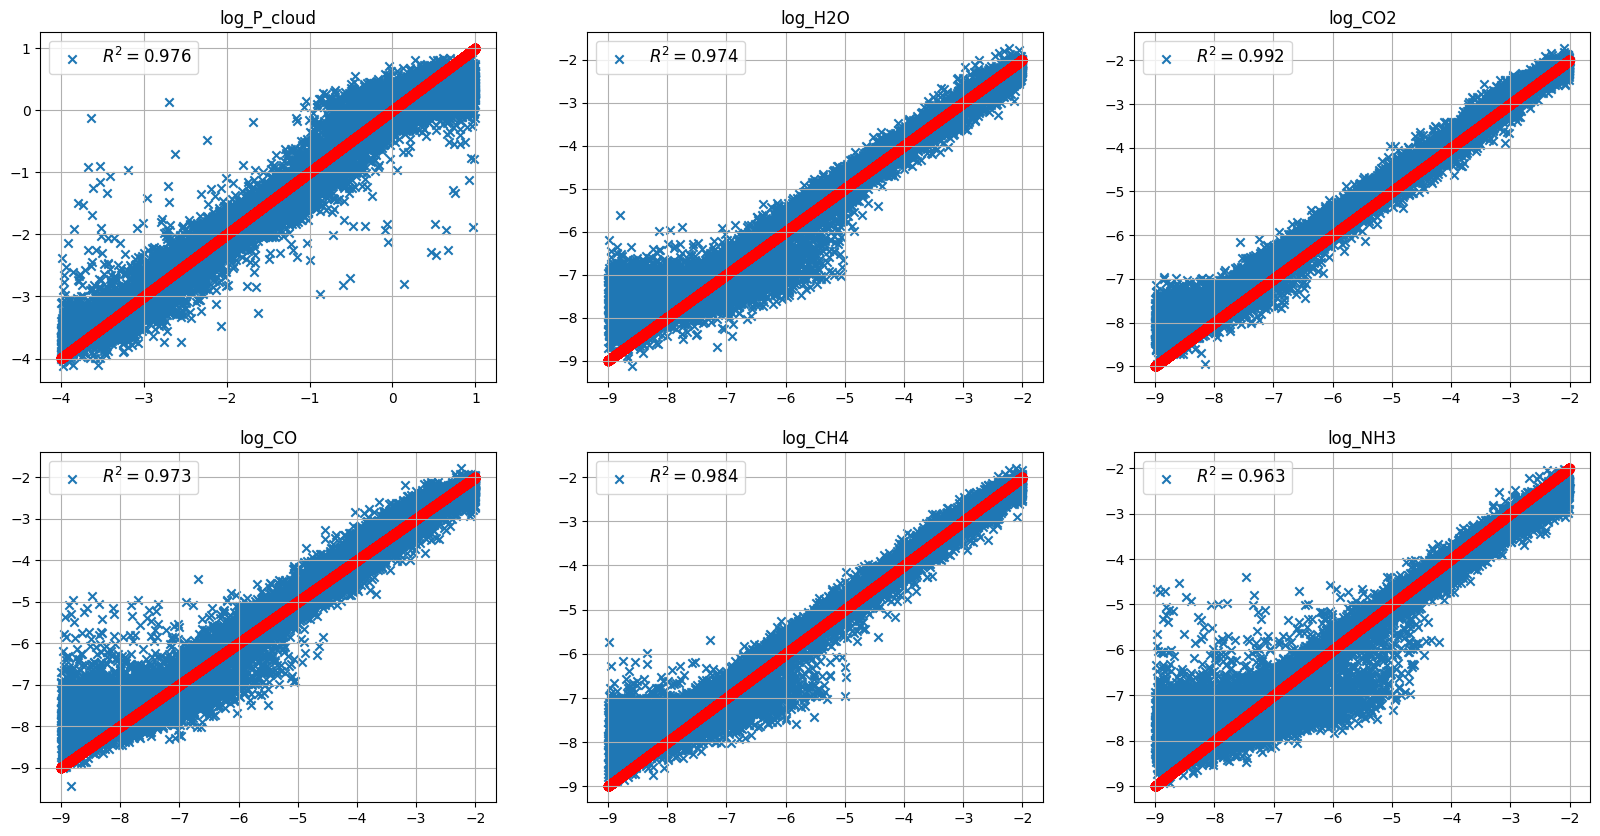

In [16]:
from scipy.stats import pearsonr

keys = ['log_P_cloud', 'log_H2O', 'log_CO2', 'log_CO', 'log_CH4', 'log_NH3']
fig, axs = plt.subplots(2, 3, figsize=(20,10))

for i in range(6):
    if i < 3:
        corr, _ = pearsonr(predictions[:,i], y_test[:,i])
        axs[0,i].scatter(y_test[:,i],predictions[:,i], marker='x', label=f'$R^{2} = ${corr:.3f}')
        axs[0,i].scatter(y_test[:,i],y_test[:,i], color='red')
        axs[0,i].set_title(keys[i])
        axs[0,i].legend(loc='upper left',fontsize=12)
        axs[0,i].grid()
    else:
        corr, _ = pearsonr(predictions[:,i], y_test[:,i])
        axs[1,i-3].scatter(y_test[:,i],predictions[:,i], marker='x',label=f'$R^{2} = ${corr:.3f}')
        axs[1,i-3].scatter(y_test[:,i],y_test[:,i], color='red')
        axs[1,i-3].set_title(keys[i])
        axs[1,i-3].legend(loc= 'upper left',fontsize=12)
        axs[1,i-3].grid()